# Data Utility Learning

This notebook introduces **Data Utility Learning** (DUL), a method for approximate data valuation which learns a model of the utility function.

The idea is to estimate the performance of the learning algorithm of interest on unseen data combinations (i.e. subsets of the dataset). The method was originally described in *Wang, Tianhao, Yu Yang, and Ruoxi Jia. [Improving Cooperative Game Theory-Based Data Valuation via Data Utility Learning](https://doi.org/10.48550/arXiv.2107.06336). arXiv, 2022*.

<div class="alert alert-warning">
    <p><b>Warning:</b> Work on Data Utility Learning is preliminary. It remains to be seen when or whether it can be put effectively into application. For this further testing and benchmarking are required.</p>
</div>

## Setting and notation

DUL can be applied to any semi-value-based data valuation method. Banzhaf, Beta-Shapley, etc. In this notebook we will focus on Shapley Value. Assume we have some machine learning model, say a classifier $M$, trained on a dataset $D=\{x_1, ..., x_n\}$. For notational convenience we identify points $x_i$ with their indices $i \in N=\{1, ..., n\}$. We also have a separate _valuation set_ $D_{val}$, and define the _utility_ of a subset $S \subset N$ as the performance (e.g. accuracy) of $M$ when trained on $S$ and evaluated on $D_{val}$.

Then, the definition of Shapley Value $v_u(i)$ for $i \in N$ is:

\begin{equation}
v_u(i) = \frac{1}{n} \sum_{S \subseteq N \setminus \{i\}} \binom{n-1}{|S|}^{-1} [u(S \cup \{i\}) − u(S)],
\tag{1}
\label{eq:shapley-def}
\end{equation}


Because each evaluation of $u(S)$ requires a potentially very costly training of $M$ on $S$, the idea of DUL is to learn a surrogate model $\hat{u}$ for the utility. The main assumption is that it is much faster to fit and use $\hat{u}$ than it is to compute $u$ and that for most $i$, $v_\hat{u}(i) \approx v_u(i)$ in some sense.

In order to fit $\hat{u}$, we start by sampling so-called **utility samples** to form a training set $S_\mathrm{train}$. Each utility sample is a tuple consisting of a subset of indices $S_j,$ and its true utility $u(S_j)$:

$$\mathcal{S}_\mathrm{train} = \{(S_j, u(S_j): S_j \subset N, j = 1 , ..., m_\mathrm{train}\}$$

where $m_\mathrm{train}$ denotes the *training budget* for the learned utility function.

The **data utility model** $\hat{u}$ takes as input sets $S$, which we must encode somehow. In the DUL paper, the authors use 1-hot encoding for the data points, i.e. they use an indicator function for $S$, which is a boolean vector $\phi$ in which a $1$ at index $k$ means that the $k$-th sample of the dataset is present in the subset:

$$S_j \mapsto \phi_j \in \{ 0, 1 \}^{N}, \text{ where }\phi_j^k = 1 \text{ iff }x_k \in S_j.$$

We train $\hat{u}$ on the transformed utility samples $\phi (\mathcal{S}_\mathrm{train}) := \{(\phi(S_j), u(S_j): j = 1 , ..., m_\mathrm{train}\},$ and then use it to predict instead of computing the utility for any $S_j \notin \mathcal{S}_\mathrm{train}$.

## Alternative encodings

Training e.g. a neural network $\hat{u}$ on a set of corners of an $N$-dimensional unit cube is generally not the best approach, so one can think of alternative encodings. One such possibility are **DeepSets**, introduced by [Zaheer et al. (2017)](https://proceedings.neurips.cc/paper/2017/hash/f22e4747da1aa27e363d86d40ff442fe-Abstract.html), which learn an encoding for the sets as part of the training procedure. This is done by ensuring that the network is permutation-invariant, which is the main property of interest when learning a function defined over sets.

pyDVL offers a very simple pytorch implementation of DeepSets through [DeepSetUtilityModel][pydvl.valuation.utility.deepset.DeepSetUtilityModel]. You can implement your own by subclassing [UtilityModel][pydvl.valuation.utility.learning.UtilityModel].

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%matplotlib inline

import os
import random
import warnings
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from tqdm.auto import tqdm

from pydvl.reporting.plots import shaded_mean_std

plt.ioff()  # Prevent jupyter from automatically plotting
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

random_state = 42

train_size = 15
batch_size = 32
training_budgets = np.logspace(2, np.log10(4000), num=8, base=10).astype(int)
n_runs = 10
n_jobs = 16

is_CI = os.environ.get("CI")

if is_CI:
    train_size = 4
    batch_size = 1
    training_budgets = [2, 4, 6]
    n_runs = 1
    n_jobs = 1

random.seed(random_state)
np.random.seed(random_state)

# raised by joblib after cancelling running tasks
warnings.simplefilter("ignore", UserWarning)

computation_times = defaultdict(list)

Data utility learning can be applied to any valuation method that uses a Utility, in particular any [SemivalueValuation][pydvl.valuation.methods.semivalue.SemivalueValuation]. For this example we will use Shapley values with the subclass [ShapleyValuation][pydvl.valuation.methods.shapley.ShapleyValuation].

## Dataset

Closely following the paper, we take `train_size=15` samples (10%) from the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and compute their Data Shapley values by using all the remaining samples as test set for computing the utility, which in this case is accuracy.

In [2]:
from pydvl.valuation.dataset import Dataset

train, test = Dataset.from_sklearn(
    load_iris(),
    train_size=train_size,
    random_state=random_state,
    stratify_by_target=True,
)

We verify that, as in the paper, if we fit a Support-Vector Classifier to the training data, we obtain a high accuracy:

In [3]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(*train.data());

In [4]:
print(f"Mean accuracy: {100 * model.score(*test.data()):0.2f}%")

Mean accuracy: 94.07%


## Computing exact Shapley values

We start by defining the utility using the main model of interest and computing the exact Data Shapley values by definition $\ref{eq:shapley-def}$.

We require a [SupervisedScorer][pydvl.valuation.scorers.supervised.SupervisedScorer] (accuracy), and a [ModelUtility][pydvl.valuation.utility.modelutility.ModelUtility] (not to be confused with DUL's model _for_ the utility, which is `UtilityModel`!).

In [5]:
from pydvl.valuation import ModelUtility, SupervisedScorer

scorer = SupervisedScorer("accuracy", test_data=test, default=0, range=(0, 1))
utility = ModelUtility(model=model, scorer=scorer, show_warnings=False)

Then we must pick the sampling scheme. In order to compute exact values we must use either [DeterministicUniformSampler][pydvl.valuation.samplers.powerset.DeterministicUniformSampler] which yields all possible subsets of the data or [DeterministicPermutationSampler][pydvl.valuation.samplers.permutation.DeterministicPermutationSampler] which yields all possible permutations of the data, but the latter is prohibitively expensive.

Finally, we must pick a stopping criterion. Since the sampler is finite, we use [NoStopping][pydvl.valuation.stopping.NoStopping] to run until completion and we pass it the sampler to keep track of progress.

In [6]:
from pydvl.valuation import (
    DeterministicUniformSampler,
    NoStopping,
    ShapleyValuation,
)

sampler = DeterministicUniformSampler(batch_size=32)
stopping = NoStopping(sampler)

valuation = ShapleyValuation(
    utility=utility, sampler=sampler, is_done=stopping, progress=True
)

With everything set up, we fit the valuation in parallel and obtain the exact Data Shapley values:

In [7]:
from joblib import parallel_config

from pydvl.utils.functional import timed

timed_fit = timed(valuation.fit)
with parallel_config(n_jobs=n_jobs):
    timed_fit(train)
computation_times["exact"] = timed_fit.execution_time

result = valuation.result
df = result.to_dataframe(column="exact")["exact"]  # We only need the values

ShapleyValuation: NoStopping(): 0.00%|          | [00:00<?, ?%/s]

## Learning the utility with a simple neural network

We now estimate the Data Shapley values with [DataUtilityLearning][pydvl.valuation.utility.learning.DataUtilityLearning]. This class learns a model of the `Utility` by wrapping it and delegating calls to it, up until a given budget. Every call yields a _utility sample_ which is saved under the hood for training of the given utility model. Once the budget is exhausted, `DataUtilityLearning` fits the model to the utility samples and all subsequent calls use the learned model to predict the wrapped utility. Because each evaluation of the original utility is assumed to take a long time, this results in a speedup.

<div class="alert alert-info">

Note how we use a Monte Carlo approximation instead of sampling all subsets as above. This is not only for speed reasons, but because [DeterministicUniformSampler][pydvl.valuation.samplers.powerset.DeterministicUniformSampler] yields subsets in a fixed order, from the lowest size to the largest. Because the training budget for the model to learn the utility is around 1/4th of the total number of subsets, this would mean that we would never see utility samples for the larger sizes and the model would be biased (try it!)

</div>

Below are the parameters for the model used to learn the utility. We follow the paper and use a fully connected neural network whose inputs are indicator vectors of the sets. For a set $S = \{i_1, ..., i_m\}$, the encoding is a binary vector $x$ such that $x_i = 1$ if $i \in S$ or $0$ otherwise. The process of encoding the data and fitting the neural network is encapsulated inside an [IndicatorUtilityModel][pydvl.valuation.utility.learning.IndicatorUtilityModel]. Other choices inherit from the ABC [UtilityModel][pydvl.valuation.utility.learning.UtilityModel]. We will see an example later.

In [8]:
mlp_params = dict(
    hidden_layer_sizes=(20, 10),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=batch_size,
    max_iter=800,
    shuffle=False,
    random_state=random_state,
)

For the training we use an increasing `training_budget` of utility samples, spaced on a log scale from 100 to 4000. We repeat each training procedure 10 times in order to compute confidence intervals.
Each experiment is encapsulated in the function `run_once`, which takes a run identifier and a DUL budget, then performs the fitting and returns all information as a tuple

In [17]:
from joblib import Parallel, delayed
from sklearn.neural_network import MLPRegressor

from pydvl.utils.functional import suppress_warnings, timed
from pydvl.valuation.result import ValuationResult
from pydvl.valuation.samplers import PermutationSampler
from pydvl.valuation.samplers.truncation import RelativeTruncation
from pydvl.valuation.stopping import MaxUpdates
from pydvl.valuation.utility import DataUtilityLearning
from pydvl.valuation.utility.learning import IndicatorUtilityModel


@suppress_warnings(categories=(RuntimeWarning,))
def run_once(run: int, budget: int) -> tuple[int, int, ValuationResult, float]:
    # DUL will kick in after `budget` calls to utility
    utility_model = IndicatorUtilityModel(MLPRegressor(**mlp_params), n_data=len(train))
    dul_utility = DataUtilityLearning(
        utility=utility,
        training_budget=budget,
        model=utility_model,
        show_warnings=False,
    )

    truncation = RelativeTruncation(rtol=0.001)
    sampler = PermutationSampler(truncation=truncation)
    stopping = MaxUpdates(300)
    valuation = ShapleyValuation(dul_utility, sampler, is_done=stopping, progress=False)

    # Note that DUL does not support parallel fitting (yet?)
    timed_fit = timed(valuation.fit)
    timed_fit(train)

    return run, budget, valuation.result, timed_fit.execution_time

In [18]:
with parallel_config(n_jobs=n_jobs):
    worker = delayed(run_once)

    with Parallel(return_as="generator_unordered") as parallel:
        jobs = parallel(
            worker(run, budget)
            for run, budget in product(range(n_runs), training_budgets)
        )

        pbar = tqdm(jobs, total=n_runs * len(training_budgets))
        for run, budget, result, time in pbar:
            computation_times[budget].append(time)
            dul_df = result.to_dataframe(column=f"{budget}_{run}")[f"{budget}_{run}"]
            df = pd.concat([df, dul_df], axis=1)

  0%|          | 0/80 [00:00<?, ?it/s]

Notice how we have changed the stopping criterion to be a combination of [HistoryDeviation][pydvl.valuation.stopping.HistoryDeviation] and [MaxUpdates][pydvl.valuation.stopping.MaxUpdates]. The former stops the valuation when the relative deviation of the values is below a certain threshold for a given number of steps, and the latter stops the valuation after a given number of updates (to ensure that the valuation does not run indefinitely). `HistoryDeviation` is the criterion used in the paper introducing Truncated Monte Carlo Shapley.
Next we compute the $l_2$ error for the different training budgets across all runs and plot mean and standard deviation. We obtain results analogous to Figure 1 of the paper, verifying that the method indeed works for estimating the Data Shapley values (at least in this context).

In the plot we also display the mean and standard deviation of the computation time taken for each training budget.

In [19]:
max_len = max(len(v) for v in computation_times.values() if isinstance(v, list))
for k, v in computation_times.items():
    computation_times[k] = (
        v + [v[-1]] if isinstance(v, list) and len(v) < max_len else v
    )

In [20]:
from pydvl.utils import top_k_value_accuracy

computation_times_df = pd.DataFrame(computation_times)
errors = np.zeros((len(training_budgets), n_runs), dtype=float)
accuracies = np.zeros((len(training_budgets), n_runs), dtype=float)

top_k = 3

for i, budget in enumerate(training_budgets):
    for j in range(n_runs):
        y_true = df["exact"].values
        y_estimated = df[f"{budget}_{j}"].values
        errors[i, j] = np.linalg.norm(y_true - y_estimated, ord=2)
        accuracies[i, j] = top_k_value_accuracy(y_true, y_estimated, k=top_k)

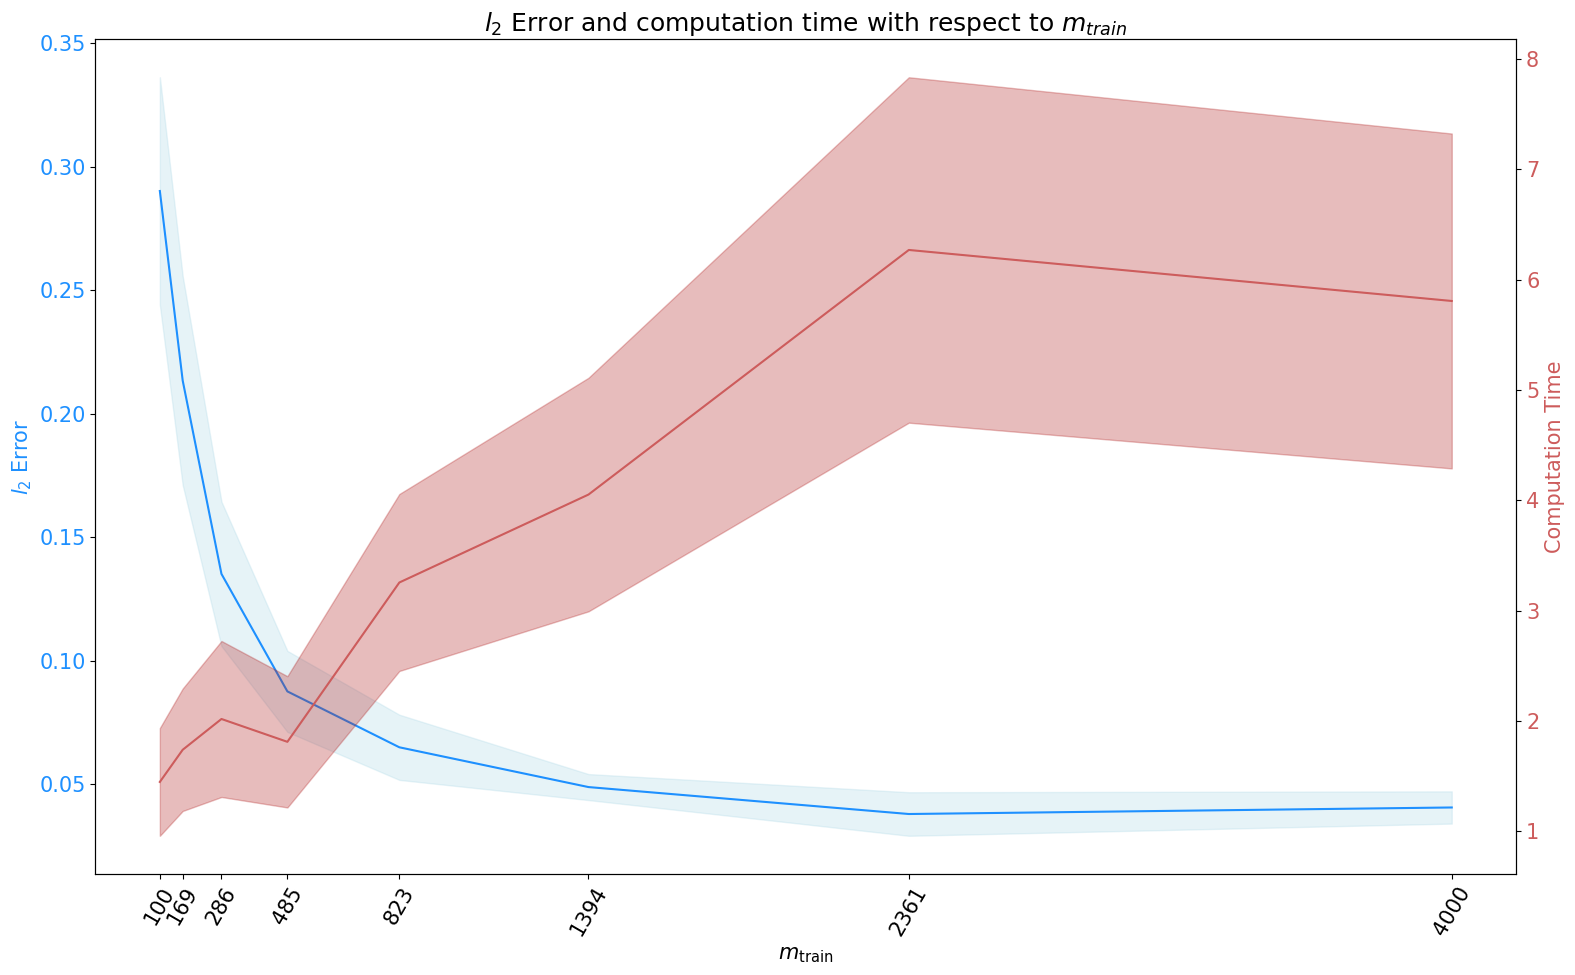

In [21]:
fig, ax = plt.subplots()
shaded_mean_std(
    errors.transpose(),
    abscissa=training_budgets,
    num_std=1,
    xlabel="$m_\\operatorname{train}$",
    ylabel="$l_2$ Error",
    label="Estimated values",
    mean_color="dodgerblue",
    shade_color="lightblue",
    ax=ax,
)
ax.set_ylabel("$l_2$ Error", color="dodgerblue")
ax.tick_params(axis="y", labelcolor="dodgerblue")

ax2 = ax.twinx()
shaded_mean_std(
    computation_times_df.drop(columns="exact"),
    abscissa=training_budgets,
    num_std=1,
    xlabel="$m_\\operatorname{train}$",
    ylabel="Time",
    label="Estimated values",
    mean_color="indianred",
    shade_color="firebrick",
    ax=ax2,
)
ax2.set_ylabel("Computation Time", color="indianred")
ax2.tick_params(axis="y", labelcolor="indianred")
ax.set_title("$l_2$ Error and computation time with respect to $m_{train}$")
fig.tight_layout()
plt.show();

Let us next look at how well the ranking of values resulting from using the surrogate $\tilde{u}$ matches the ranking by the exact values. For this we fix $k=3$ and consider the $k$ samples with the highest value according to $\tilde{u}$ and $u$:

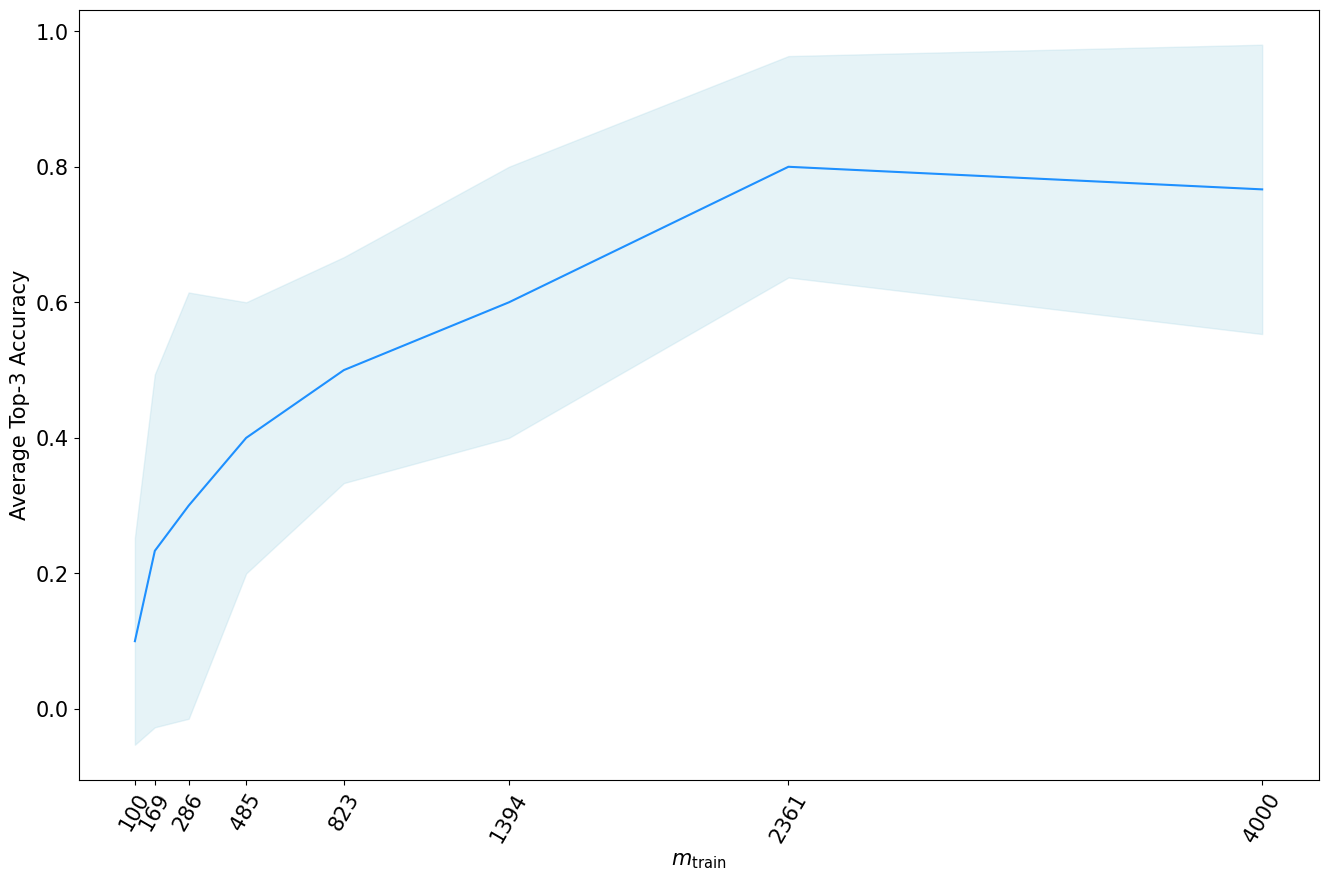

In [22]:
shaded_mean_std(
    accuracies.transpose(),
    abscissa=training_budgets,
    mean_color="dodgerblue",
    shade_color="lightblue",
    xlabel="$m_\\operatorname{train}$",
    ylabel=f"Average Top-{top_k} Accuracy",
)
plt.show();

Finally, for each sample, we look at the distance of the estimates to the exact value across runs. Boxes are centered at the 50th percentile with wiskers at the 25th and 75th. We plot relative distances, as a percentage.

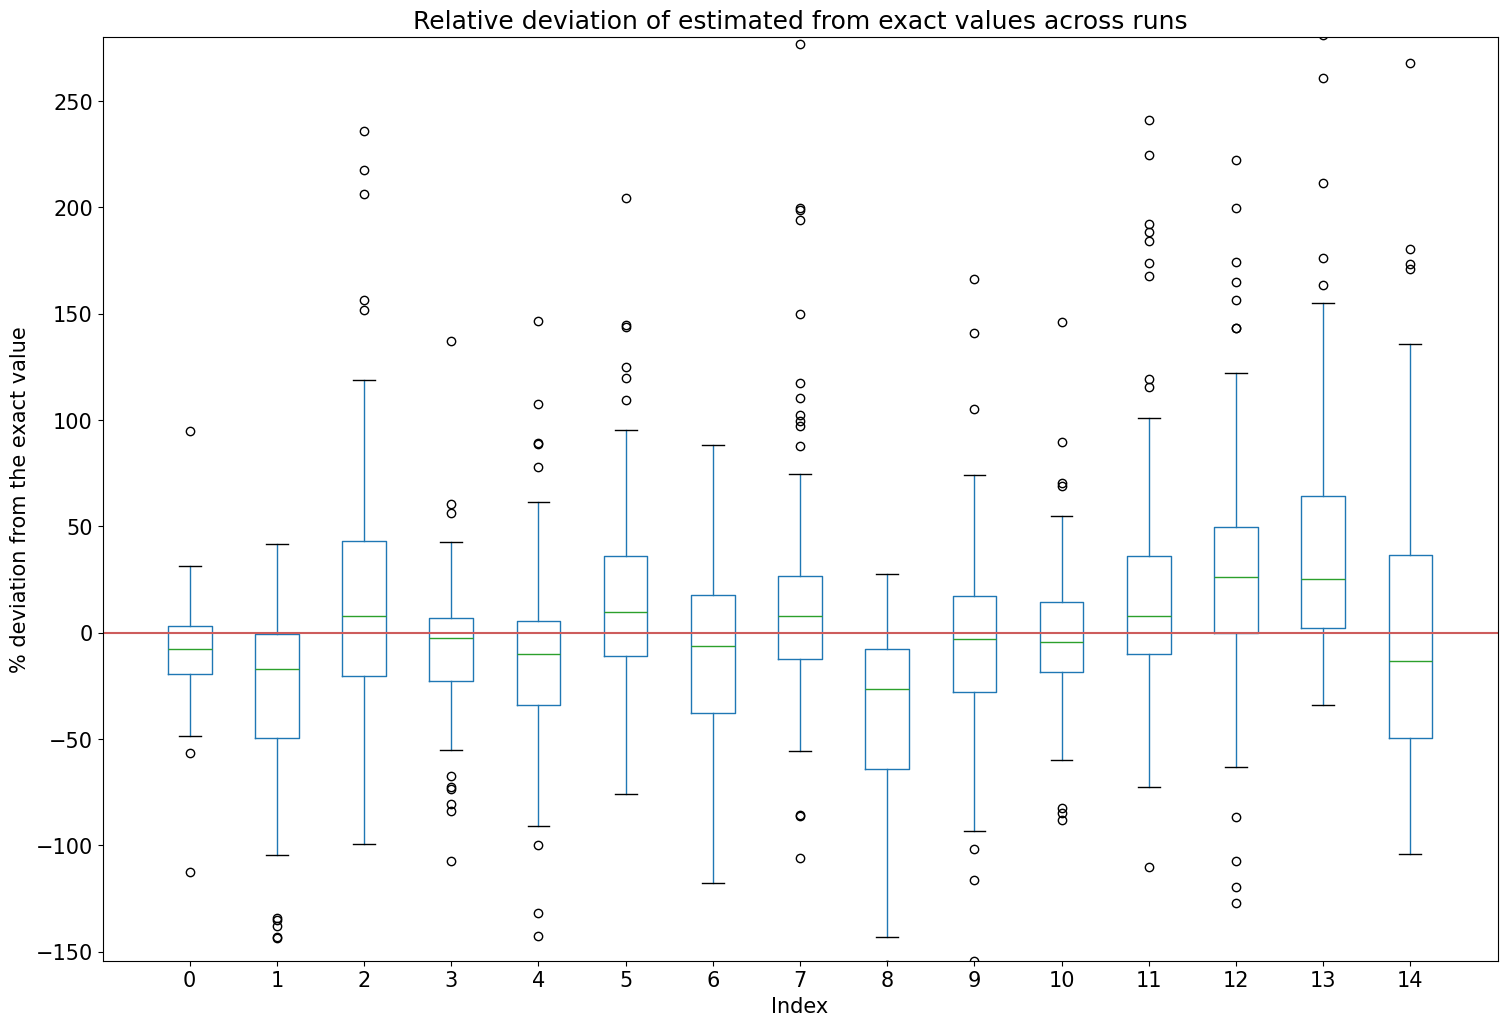

In [24]:
warnings.simplefilter("ignore", RuntimeWarning)  # numpy complains about stuff

fig, ax = plt.subplots(figsize=(18, 12))
distances = 100 * df.loc[:, df.columns != "exact"].sub(df.exact, axis="index").div(
    df.exact, axis="index"
)
distances.transpose().boxplot(column=distances.index.values.tolist(), ax=ax)
ax.hlines(0.0, 0, distances.index.max() + 2, "indianred")
ax.set_xlim((0, distances.index.max() + 2))
# Display 96% of the data:
ax.set_ylim(
    (
        distances.transpose().quantile(0.04).min(),
        distances.transpose().quantile(0.96).max(),
    )
)

ax.set_xlabel("Index")
ax.set_ylabel("% deviation from the exact value")
ax.set_title("Relative deviation of estimated from exact values across runs")
ax.grid(False)
plt.show();

This is the distribution of values across all runs

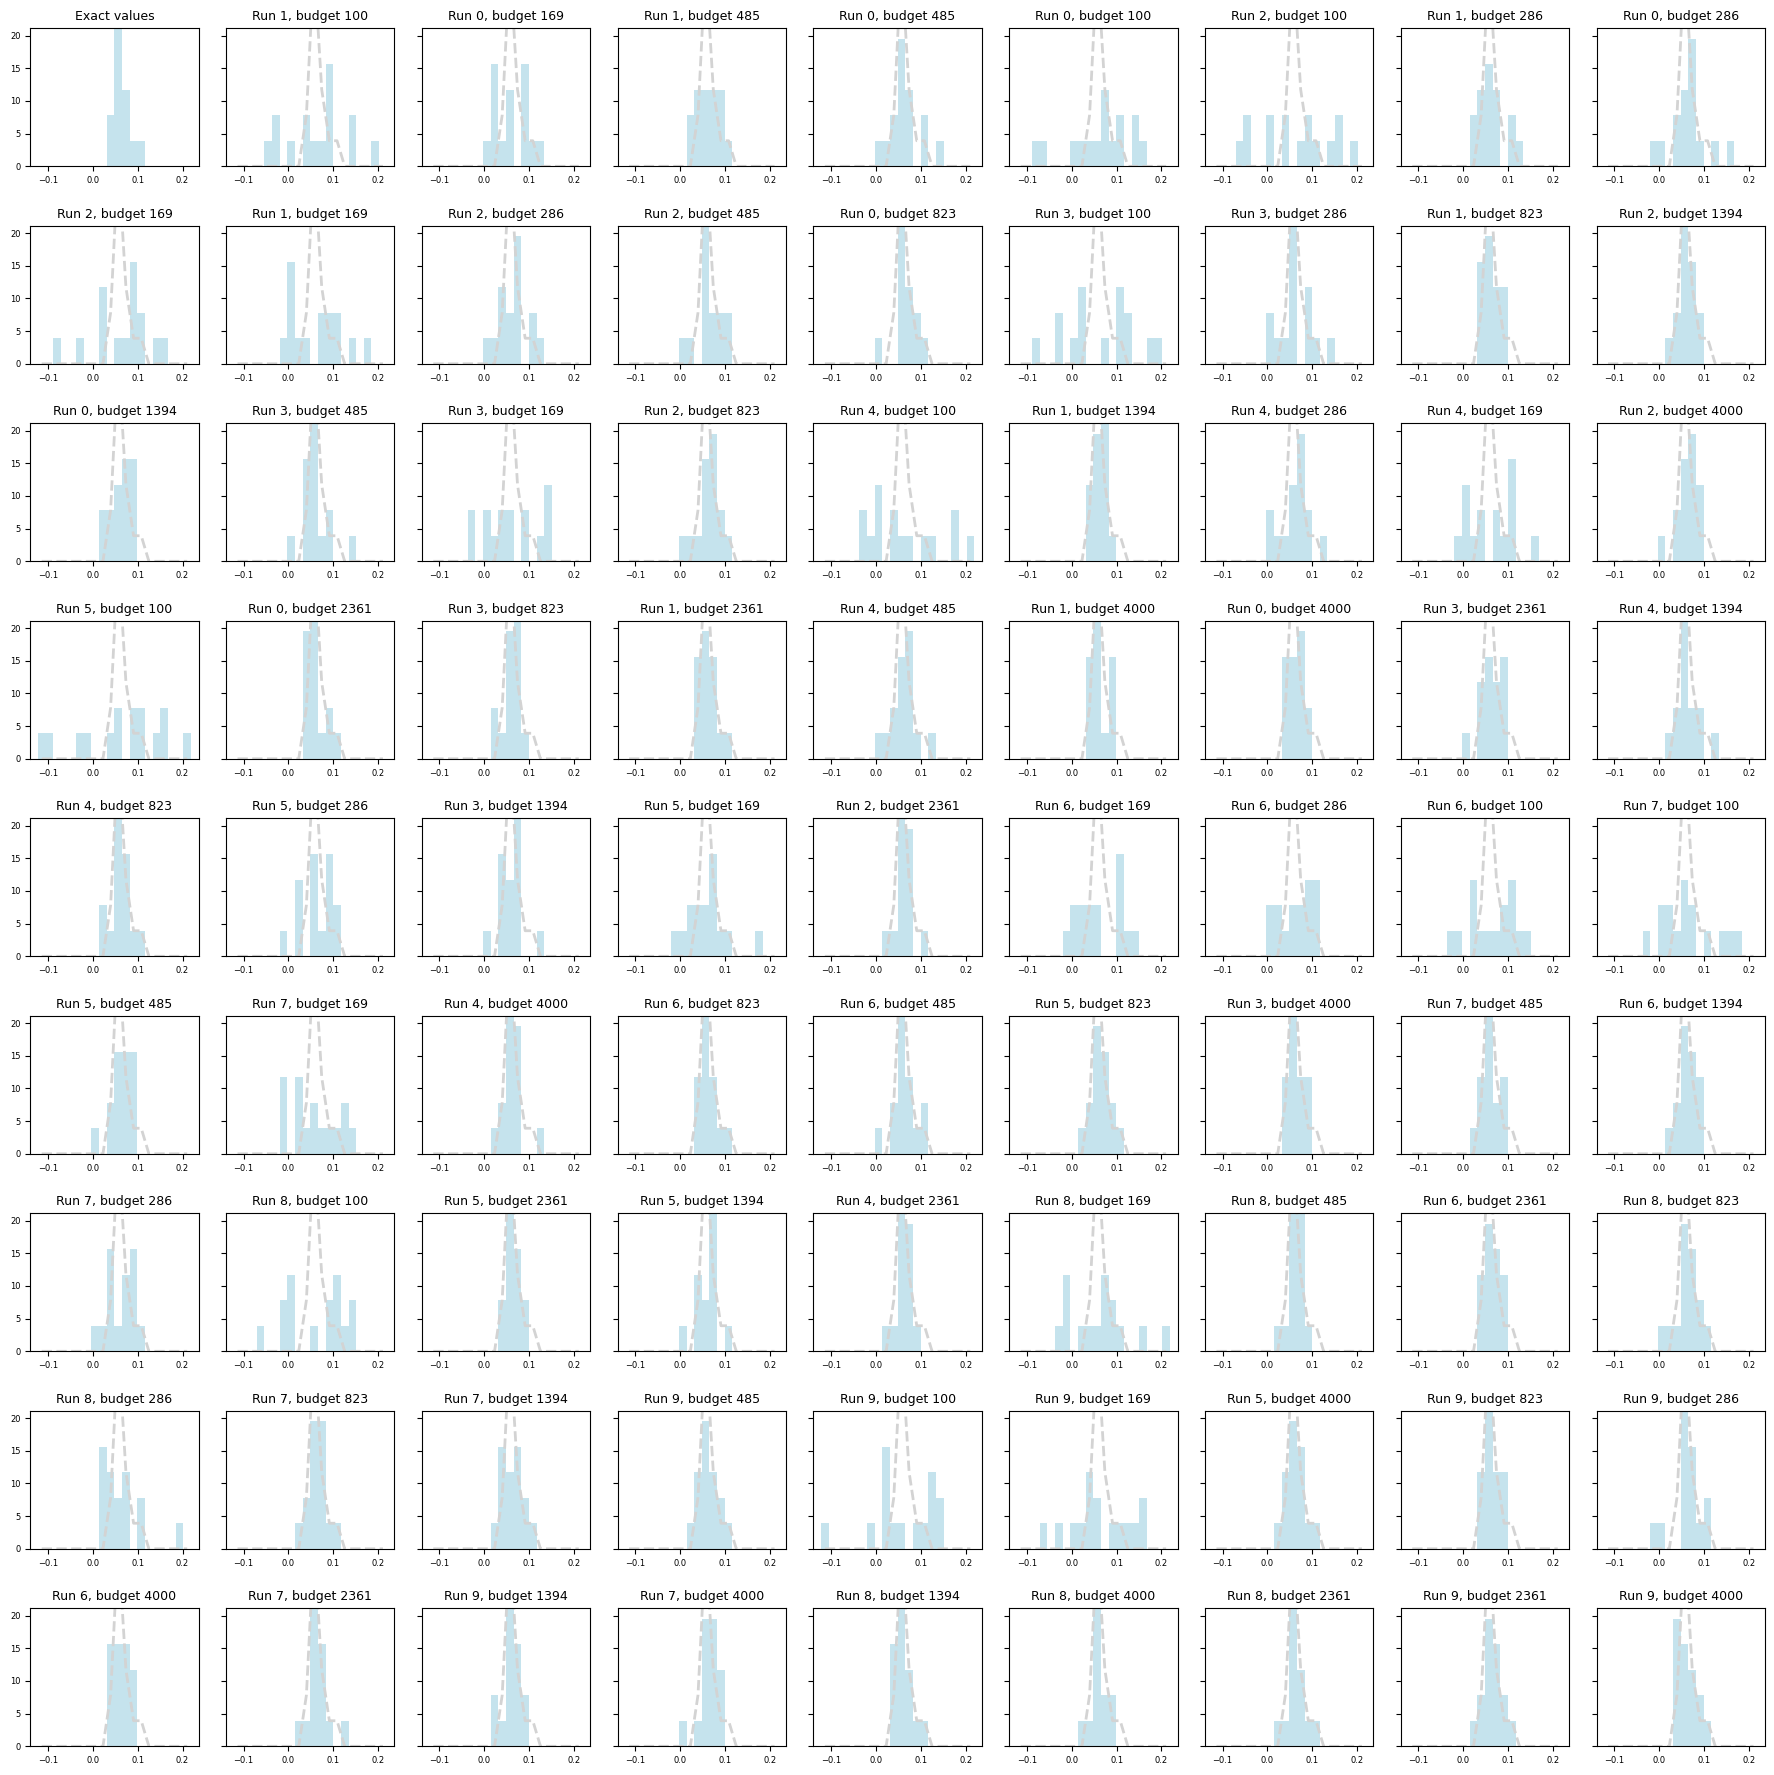

In [25]:
if not is_CI:
    bins = 20

    # Compute a global range for all histograms.
    global_min = df.min().min()
    global_max = df.max().max()

    # Use fixed bin edges for consistency.
    bin_edges = np.linspace(global_min, global_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute the global maximum density to use the same y-axis across plots.
    global_max_density = 0
    for col in df.columns:
        data = df[col].dropna()
        hist, _ = np.histogram(data, bins=bin_edges, density=True)
        global_max_density = max(global_max_density, hist.max())

    # Compute density for the first column (used as the reference overlay).
    data_first = df.iloc[:, 0].dropna()
    hist_first, _ = np.histogram(data_first, bins=bin_edges, density=True)

    fig, axes = plt.subplots(9, 9, figsize=(18, 18))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        data = df.iloc[:, i].dropna()
        ax.hist(data, bins=bin_edges, density=True, color="lightblue", alpha=0.7)

        # Overlay the first column's density curve on all plots except the first one.
        if i != 0:
            ax.plot(
                bin_centers, hist_first, color="lightgray", linestyle="--", linewidth=2
            )

        ax.set_ylim(0, global_max_density * 0.6)

        if i > 0:
            budget, run = df.columns[i].split("_")
            title = f"Run {run}, budget {budget}"
        else:
            title = "Exact values"

        ax.set_title(title, fontsize=9)

        ax.tick_params(axis="both", labelsize=6)

        if i % 9 != 0:
            ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()

## Evaluation on anomalous data

One interesting way to assess the Data Utility Learning approach is to corrupt some data and monitor how the value changes. To do this, we will take the sample with the highest score and change its label.

In [26]:
highest_value_index = df.index[df["exact"].argmax()]
y_corrupted = train.data().y.copy()
y_corrupted[highest_value_index] = (y_corrupted[highest_value_index] + 1) % 3

corrupted_dataset = Dataset(
    train.data().x.copy(),
    y_corrupted,
    feature_names=train.feature_names,
    target_names=train.target_names,
)

In [27]:
print(f"The corrupted sample has index {highest_value_index}")

The corrupted sample has index 0


We retrain the model on the new dataset and verify that the accuracy decreases:

In [28]:
model = LinearSVC()
model.fit(*corrupted_dataset.data());

In [29]:
print(
    f"Mean accuracy over test set, with corrupted training data: {100 * model.score(*test.data()):0.2f}%"
)

Mean accuracy over test set, with corrupted training data: 71.85%


Now we recompute the values of all samples using the exact method:

In [30]:
sampler = DeterministicUniformSampler(batch_size=32)
stopping = NoStopping(sampler)
valuation = ShapleyValuation(
    utility=utility, sampler=sampler, is_done=stopping, progress=True
)

with parallel_config(n_jobs=n_jobs):
    valuation.fit(corrupted_dataset)
result = valuation.result

df_corrupted = result.to_dataframe(column="exact")["exact"]

ShapleyValuation: NoStopping(): 0.00%|          | [00:00<?, ?%/s]

And finally we use DUL with the best training budget previously obtained, and plot the resulting scores.

In [31]:
best_budget = training_budgets[errors.mean(axis=1).argmin()]
print(f"Best training budget was: {best_budget}")

Best training budget was: 2361


In [34]:
scorer = SupervisedScorer("accuracy", test_data=test, default=0, range=(0, 1))
utility = ModelUtility(model=model, scorer=scorer, show_warnings=False)
utility_model = IndicatorUtilityModel(MLPRegressor(**mlp_params), n_data=len(train))
dul_utility = DataUtilityLearning(
    utility=utility,
    training_budget=best_budget,
    model=utility_model,
    show_warnings=False,
)

truncation = RelativeTruncation(rtol=0.001)
sampler = PermutationSampler(truncation=truncation)
stopping = MaxUpdates(300)
valuation = ShapleyValuation(dul_utility, sampler, is_done=stopping, progress=False)
valuation.fit(corrupted_dataset)
result = valuation.result

dul_df = result.to_dataframe(column="estimated")["estimated"]
df_corrupted = pd.concat([df_corrupted, dul_df], axis=1)

We can see in the figure that both methods assign the lowest value to the sample with the corrupted label.

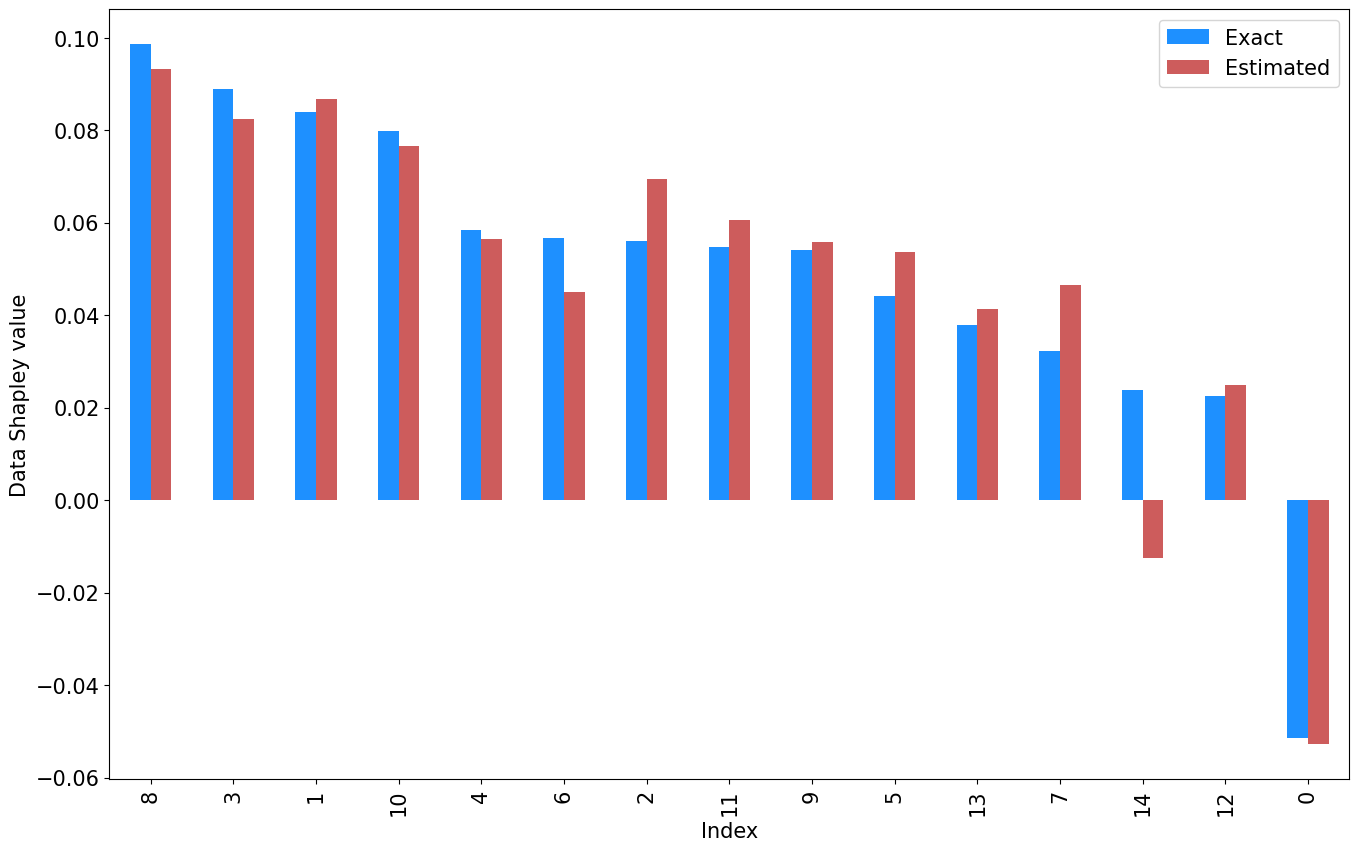

In [36]:
fig, ax = plt.subplots()
df_corrupted.sort_values(by="exact", ascending=False, axis=0).plot(
    y=["exact", "estimated"], kind="bar", ax=ax, color=["dodgerblue", "indianred"]
)
ax.set_xlabel("Index")
ax.set_ylabel("Data Shapley value")
plt.legend(["Exact", "Estimated"])
plt.show();

<div class="alert alert-warning">
As mentioned above, despite the previous results, this work is preliminary and the usefulness of Data Utility Learning remains to be tested in practice.
</div>
